In [1]:
# 참조 : https://www.tensorflow.org/tutorials/text/text_classification_rnn

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

def display_graph():
    plt.figure(figsize=(16,5))

    # 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.show()

# imdb_reviews에 있는 subwords8k dataset을 가져옵니다. subwords8k은 8k 단어로 미리 encoding 된 버전입니다.
dataset, info = tfds.load('imdb_reviews/subwords8k', 
                          with_info=True,  # 'info' 를 포함하도록 한다.
                          as_supervised=True)  # dataset 이 (data, label) 형식을 갖도록 한다. 
# dataset을 train dataset과 test dataset으로 나누어 넣습니다.
train_dataset, test_dataset = dataset['train'], dataset['test']

# dataset info에 text encoder(tfds.features.text.SubwordTextEncoder)를 포함시켜 줍니다.
# 이 encoder는 모든 문자열을 encoding/decoding 할 수 있습니다.
encoder = info.features['text'].encoder
# 이 encoder로 encode/decode 할 수 있는 단어의 크기를 출력합니다. 
print('Vocabulary size:{}'.format(encoder.vocab_size))

# encoder encode/decode 테스트
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

# sample_string 이 original_string 과 같은지 확인합니다.
assert original_string == sample_string

for index in encoded_string:
  print ('{} ----> {}'.format(index, encoder.decode([index])))

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteGX69VO/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteGX69VO/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteGX69VO/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.
Vocabulary size:8185
Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."
4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [2]:
# dataset 이 몇개씩 있는지 확인
len(train_dataset), len(test_dataset)

(25000, 25000)

In [3]:
# dataset 이 어떻게 들어 있는지 확인
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975]
label:  0


In [4]:
# encoding 되어 있는 영화평을 다시 decoding 하여 origial 문장(영화평)을 확인한다.
txt_string = encoder.decode(example)
print(txt_string)

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.


In [5]:
BUFFER_SIZE = 10000  # 10000 단위로 섞음
BATCH_SIZE = 64      # batch 당 영화평(시퀀스)의 갯수

train_dataset = train_dataset.shuffle(BUFFER_SIZE)  # shuffle은 BUFFER_SIZE 단위로 섞어줍니다.

# padded_batch 메서드를 사용하면 각 batch 마다 가장 긴 영화평(시퀀스)의 길이를 기준으로 0 로 채웁니다.(고정된 길이로 세팅)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)  # batch 당 BATCH_SIZE 개의 영화평을 담습니다. 

test_dataset = test_dataset.padded_batch(BATCH_SIZE) # batch 당 BATCH_SIZE 개의 영화평을 담습니다.

In [6]:
# 하나의 batch 에 담긴 3개의 영화평만 가져옵니다.
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [[2016 1259    2 ...    0    0    0]
 [1698    2  920 ...    0    0    0]
 [ 750  783  783 ...    0    0    0]]

labels:  [0 1 0]


In [7]:
# 하나의 batch 에 담긴 영화평의 갯수를 확인합니다.
print(len(example))

64


In [8]:
# 첫번째 영화평의 내용을 decoding 하여 내용을 확인합니다.
print(encoder.decode(example[0]))

Well then, what is it?! I found Nicholson's character shallow and most unfortunately uninteresting. Angelica Huston's character drained my power. And Kathleen Turner is a filthy no good slut. It's not that I "don't get it". It's not that I don't think that some of the ideas could've lead to something more. This is a film with nothing but the notion that we're supposed to accept these ideas, and that's what the movie has going for it. That Nicholson falls for Turner is absurd, but then again, it is intended to be so. This however does not strike me as a.)funny, or b.)...even remotely interesting!!! This was a waste of my time, so don't let the hype get the best of you...it is a waste of your time! With all that being said, the opening church sequence is quite beautiful...


In [9]:
# 이번 batch 에서 최대크기(고정된 크기)를 확인합니다.
print(len(example[0]))

1430


In [ ]:
# Bi-directional LSTM 구조 참조
# http://intelligence.korea.ac.kr/members/wschoi/nlp/deeplearning/Bidirectional-RNN-and-LSTM/

Epoch 1/10
391/391 [==============================] - 77s 109ms/step - loss: 0.6796 - accuracy: 0.5397 - val_loss: 0.4569 - val_accuracy: 0.8026
Epoch 2/10
391/391 [==============================] - 42s 106ms/step - loss: 0.3655 - accuracy: 0.8524 - val_loss: 0.3494 - val_accuracy: 0.8609
Epoch 3/10
391/391 [==============================] - 42s 107ms/step - loss: 0.2473 - accuracy: 0.9093 - val_loss: 0.3351 - val_accuracy: 0.8708
Epoch 4/10
391/391 [==============================] - 42s 107ms/step - loss: 0.2202 - accuracy: 0.9197 - val_loss: 0.3418 - val_accuracy: 0.8599
Epoch 5/10
391/391 [==============================] - 42s 107ms/step - loss: 0.1845 - accuracy: 0.9365 - val_loss: 0.3478 - val_accuracy: 0.8661
Epoch 6/10
391/391 [==============================] - 43s 108ms/step - loss: 0.1566 - accuracy: 0.9495 - val_loss: 0.3728 - val_accuracy: 0.8625
Epoch 7/10
391/391 [==============================] - 43s 108ms/step - loss: 0.1396 - accuracy: 0.9563 - val_loss: 0.3732 - val_ac

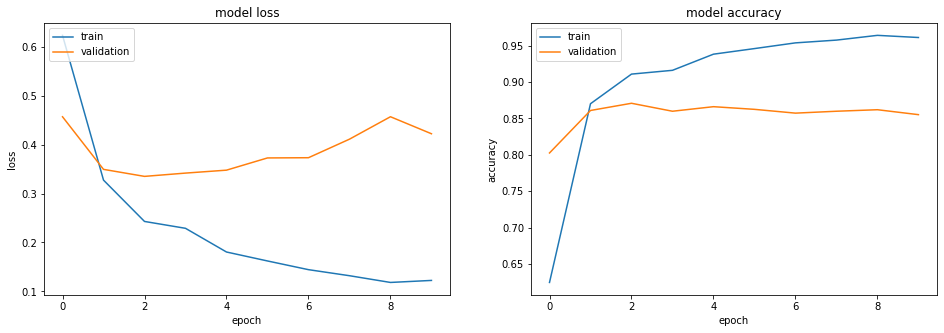

In [10]:
# 모델 구성하기
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),          # 8185 개의 단어를 사용하여, 영화평(시퀀스)을 구성하는 각 단어(Word)에 대해 64 차원(Dimension)의 Vector로 바꿔준다. 총 64개의 단어를 입력. 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),    # RNN Cell 또는 LSTM Cell 사용을 지정할 수 있으며, Output 64
    tf.keras.layers.Dense(64, activation='relu'),               # 출력 결과를 Fully Connected Layer(Dense)에 연결
    tf.keras.layers.Dense(1, activation='sigmoid')              # 최종 출력 결과는 1자리
])

# 모델 학습과정 설정하기
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


# 모델 학습시키기
history = model.fit(train_dataset, 
                    epochs=10,
                    verbose=1,
                    validation_data=test_dataset,
                    validation_steps=30)
                    
# 모델 요약
model.summary()

# 모델 평가하기
score = model.evaluate(test_dataset, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 그래프 출력
display_graph()

In [11]:
# 0로 padding을 해주는 함수 정의
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

# 문자열을 입력 받아 예측결과를 반환해 주는 함수 정의
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)  # 문자열을 encoding   

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)   # pad='True'이면 padding 처리
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32) 
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0)) # encode된 Text로 예측하기

  return (predictions)

In [12]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.47121644]]


In [13]:
# predict on a sample text with padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.4718085]]


In [14]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was bad. The animation and the graphics '
                    'were out of sense. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.18728256]]


In [15]:
# predict on a sample text with padding.

sample_pred_text = ('The movie was bad. The animation and the graphics '
                    'were out of sense. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.1136614]]


In [16]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was fantastic. The animation and the graphics '
                    'were so cool. I would strongly recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.6048396]]


In [17]:
# predict on a sample text with padding.

sample_pred_text = ('The movie was fantastic. The animation and the graphics '
                    'were so cool. I would strongly recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.6403487]]


Epoch 1/10
391/391 [==============================] - 78s 187ms/step - loss: 0.6831 - accuracy: 0.5305 - val_loss: 0.4973 - val_accuracy: 0.7839
Epoch 2/10
391/391 [==============================] - 73s 184ms/step - loss: 0.3968 - accuracy: 0.8414 - val_loss: 0.3728 - val_accuracy: 0.8542
Epoch 3/10
391/391 [==============================] - 73s 184ms/step - loss: 0.2739 - accuracy: 0.9016 - val_loss: 0.3476 - val_accuracy: 0.8682
Epoch 4/10
391/391 [==============================] - 73s 186ms/step - loss: 0.2256 - accuracy: 0.9278 - val_loss: 0.3678 - val_accuracy: 0.8661
Epoch 5/10
391/391 [==============================] - 74s 187ms/step - loss: 0.1811 - accuracy: 0.9461 - val_loss: 0.3914 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 73s 186ms/step - loss: 0.1537 - accuracy: 0.9566 - val_loss: 0.4153 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 74s 187ms/step - loss: 0.1422 - accuracy: 0.9611 - val_loss: 0.4363 - val_ac

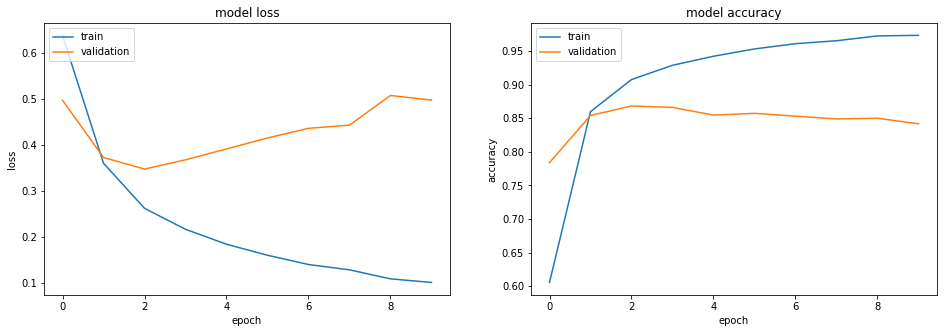

In [18]:
# 모델 구성하기(두개 이상의 LSTM Layer 쌓기)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),   # return_sequences=True : 64개의 출력(Output)을 모두 다음 Layer를 Input으로 사용하도록 하였으나 32개만 다음 Layer의 Input으로 사용
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 모델 학습과정 설정하기
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# 모델 학습시키기
history = model.fit(train_dataset, 
                    epochs=10,
                    verbose=1,
                    validation_data=test_dataset,
                    validation_steps=30)

# 모델 요약
model.summary()

# 모델 평가하기
score = model.evaluate(test_dataset, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 그래프 출력
display_graph()

In [ ]:
# Parameter 수 계산
# m : Input vector size
# n : Output vector size
# bidirectional layer Parameter 수 = 4*((m+1)*n + (n*n))*2  (+1은 bias를 의미, lstm은 4를 곱해주는데 4개의 neural network layers(3개의 gates + cell state)를 의미)
# bidirectional_1 = 4*((65*64)+(64*64))*2 = 66048
# bidirectional_2 = 4*((65*32)+(32*32))*2 + 4*((32*32)+(32*32))*2 = 41216

In [19]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.73518604]]


In [21]:
# predict on a sample text with padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.9462874]]


In [22]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was bad. The animation and the graphics '
                    'were out of sense. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.10930081]]


In [23]:
# predict on a sample text with padding.

sample_pred_text = ('The movie was bad. The animation and the graphics '
                    'were out of sense. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.04156498]]


In [25]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was fantastic. The animation and the graphics '
                    'were so cool. I would strongly recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.8116546]]


In [26]:
# predict on a sample text with padding.

sample_pred_text = ('The movie was fantastic. The animation and the graphics '
                    'were so cool. I would strongly recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.9686313]]
